# VAE-GAN
## Algorytmy inspirowane naturą

### Autorzy:
- Piotr Kubala
- Patryk Knapek
- Rafał Łukosz

### Uruchamianie uczenia:

W przypadku nie posiadania odpowiednich bibliotek, należy je zainstalować za pomocą poniższej komendy:
```bash
pip install -r requirements.txt
```

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Optimizer, RMSprop
from tqdm import tqdm
import datetime, os

from torchvision.datasets import DatasetFolder
from torchvision import transforms
from torchvision.datasets.folder import default_loader

from sklearn.decomposition import PCA
import cv2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Classes

In [3]:
class VaeEncoder(nn.Module):
    def __init__(self, image_width: int, latent_size: int, fourier_len: int = 0):
        super().__init__()
        self.image_width = image_width
        self.latent_size = latent_size

        transformed_width = image_width // 64

        self.encoder = nn.Sequential(
            nn.Conv2d(3 + fourier_len, 64, kernel_size=4, stride=2, padding=1), # image_width/2 x image_width/2
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # image_width/4 x image_width/4
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # image_width/8 x image_width/8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 328, kernel_size=4, stride=2, padding=1), # image_width/16 x image_width/16
            nn.BatchNorm2d(328),
            nn.ReLU(),
            nn.Conv2d(328, 512, kernel_size=4, stride=2, padding=1), # image_width/32 x image_width/32
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 128, kernel_size=4, stride=2, padding=1), # image_width/64 x image_width/64
            nn.Flatten() # image_width/32 x image_width/32 x 128
        )

        self.mu = nn.Linear(transformed_width * transformed_width * 128, latent_size)
        self.logvar = nn.Linear(transformed_width * transformed_width * 128, latent_size)

    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

In [4]:
class VaeDecoder(nn.Module):
    def __init__(self, image_width: int, latent_size: int):
        super().__init__()
        self.image_width = image_width
        self.latent_size = latent_size

        transformed_width = image_width // 64

        self.decoder = nn.Sequential(
            nn.Linear(latent_size, transformed_width * transformed_width * 128),
            nn.Unflatten(1, (128, transformed_width, transformed_width)),
            nn.ConvTranspose2d(128, 512, kernel_size=4, stride=2, padding=1), # image_width/32 x image_width/32
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 328, kernel_size=4, stride=2, padding=1), # image_width/16 x image_width/16
            nn.BatchNorm2d(328),
            nn.ReLU(),
            nn.ConvTranspose2d(328, 256, kernel_size=4, stride=2, padding=1), # image_width/8 x image_width/8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # image_width/4 x image_width/4
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # image_width/2 x image_width/2
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1), # image_width x image_width
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=5, padding=2, padding_mode="reflect"), # image_width x image_width
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16, kernel_size=5, padding=2, padding_mode="reflect"), # image_width x image_width
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 3, kernel_size=5, padding=2, padding_mode="reflect"), # image_width x image_width
            nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, image_width: int):
        super().__init__()
        self.image_width = image_width

        image_width_transformed = image_width // 64

        self.discriminator_back = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2)), # image_width/2 x image_width/2
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)), # image_width/4 x image_width/4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)), # image_width/8 x image_width/8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(256, 328, kernel_size=5, stride=2, padding=2)), # image_width/16 x image_width/16
            nn.BatchNorm2d(328),
            nn.LeakyReLU(0.2)
        )

        self.discriminator_head = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(328, 512, kernel_size=5, stride=2, padding=2)), # image_width/32 x image_width/32
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(512, 128, kernel_size=5, stride=2, padding=2)), # image_width/64 x image_width/64
            nn.LeakyReLU(0.2),
            nn.Flatten(), # image_width/64 x image_width/64 x 128
            nn.utils.spectral_norm(nn.Linear(image_width_transformed * image_width_transformed * 128, 1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.discriminator_back(x)
        features = x
        x = self.discriminator_head(x)

        return x, features

In [6]:
def plot_random_image(decoder: nn.Module, latent_size: int):
    random_latent = torch.randn(1, latent_size).to(device)
    reconstruction = decoder(random_latent).detach().cpu().numpy()[0].transpose(1, 2, 0) * 0.5 + 0.5

    plt.imshow(reconstruction)
    plt.axis('off')
    plt.show()

In [7]:
def plot_images(decoder: nn.Module, encoder: nn.Module, image: torch.Tensor):
    image_device = image.to(device)

    mu, logvar = encoder(image_device)
    var = torch.exp(logvar)
    std = torch.sqrt(var)
    epsilon = torch.randn_like(mu)
    latent = mu + std * epsilon

    reconstruction = decoder(latent).detach().cpu().numpy()

    image_plot = image.detach().cpu().numpy()[0][:3].transpose(1, 2, 0) * 0.5 + 0.5
    reconstruction_plot = reconstruction[0].transpose(1, 2, 0) * 0.5 + 0.5

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image_plot)
    ax[0].axis('off')
    ax[1].imshow(reconstruction_plot)
    ax[1].axis('off')
    plt.show()

In [8]:
def plot_hidden_distribution(encoder: nn.Module, dataloader: DataLoader, count_per_instance: int = 4):
    mus = []
    logvars = []

    for images, _ in tqdm(dataloader):
        images = images.to(device)
        mu, logvar = encoder(images)
        mus.append(mu.detach().cpu().numpy())
        logvars.append(logvar.detach().cpu().numpy())

    mus_array = np.concatenate(mus, axis=0)
    variance_array = np.exp(np.concatenate(logvars, axis=0))
    images_count = mus_array.shape[0]
    embedding_dim = mus_array.shape[1]

    sampled_instances = []

    for i in tqdm(range(count_per_instance)):
        instances = np.random.randn(images_count, embedding_dim) * np.sqrt(variance_array) + mus_array
        sampled_instances.append(instances)

    instances_array = np.concatenate(sampled_instances, axis=0)
    image_indices = np.repeat(np.arange(images_count), count_per_instance)

    pca = PCA(n_components=2)
    instances_pca = pca.fit_transform(instances_array)

    print(f"Explained variance: {pca.explained_variance_ratio_}")

    points_x = instances_pca[:, 0]
    points_y = instances_pca[:, 1]

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot()
    ax.scatter(points_x, points_y, c=image_indices, cmap='tab20')
    plt.show()

In [9]:
def plot_interpolate(img1: torch.Tensor, img2: torch.Tensor, encoder: nn.Module, decoder: nn.Module, steps: int = 10):
    steps_parts = torch.linspace(0, 1, steps).to(device).unsqueeze(1)
    img1 = img1.to(device)
    img2 = img2.to(device)

    mu1, logvar1 = encoder(img1)
    mu2, logvar2 = encoder(img2)

    var1 = torch.exp(logvar1)
    std1 = torch.sqrt(var1)

    var2 = torch.exp(logvar2)
    std2 = torch.sqrt(var2)

    epsilon = torch.randn_like(mu1)
    latent1 = mu1 + std1 * epsilon

    epsilon = torch.randn_like(mu2)
    latent2 = mu2 + std2 * epsilon

    latent1_repeated = latent1.repeat(steps, 1)
    latent2_repeated = latent2.repeat(steps, 1)

    interpolated_latents = latent1_repeated + (latent2_repeated - latent1_repeated) * steps_parts
    decoded_images = decoder(interpolated_latents).detach().cpu().numpy()

    transformed_images = np.zeros((steps, img1.shape[2], img1.shape[3], img1.shape[1]), dtype=np.uint8)

    for i, img in enumerate(decoded_images):
        transformed_img = ((img.transpose(1, 2, 0) * 0.5 + 0.5) * 255).astype(np.uint8)
        transformed_images[i] = transformed_img

    # plot start images
    img1_plot = img1.detach().cpu().numpy()[0].transpose(1, 2, 0) * 0.5 + 0.5
    img2_plot = img2.detach().cpu().numpy()[0].transpose(1, 2, 0) * 0.5 + 0.5

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1_plot)
    ax[0].axis('off')

    ax[1].imshow(img2_plot)
    ax[1].axis('off')
    
    plt.show()

    is_reversed = False
    should_exit = False
    while not should_exit:
        for img in (transformed_images if not is_reversed else reversed(transformed_images)):
            cv2.imshow('Interpolation', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            if cv2.waitKey(50) & 0xFF == ord('q'):
                should_exit = True
                break
        if cv2.waitKey(50) & 0xFF == ord('q'):
            break
        is_reversed = not is_reversed

    cv2.destroyAllWindows()

In [10]:
def train(encoder: nn.Module, decoder: nn.Module, discriminator: nn.Module,
          dataloader: DataLoader, epochs: int,
          encoder_optimizer: Optimizer, decoder_optimizer: Optimizer, discriminator_optimizer: Optimizer,
          img_width: int, vae_history: list[float] = [], discriminator_history: list[float] = [],
          initial_discriminator_part: int = 16, gamma: float = 0.01, eta: float = 1.0) -> list[float]:
    img_area = img_width * img_width

    MAX_DISCRIMINATOR_PART = 256
    MIN_DISCRIMINATOR_PART = 2
    discriminator_part = initial_discriminator_part
    encoder_part = 3

    generator_counter = 0
    iteration_counter = 0
    
    for i in range(epochs):
        total_loss_vae = 0
        total_loss_discriminator = 0
        total_mean_squared_error = 0
        total_accuracy = 0

        generator_part_counter = 0

        for j, (batch, _) in enumerate(tqdm(dataloader)):
            if j == 0:
                plot_images(decoder, encoder, batch[:1])

            if iteration_counter % discriminator_part != discriminator_part - 1:
                batch_device = batch.to(device)

                mu, logvar = encoder(batch_device)
                var = torch.exp(logvar)
                epsilon = torch.randn_like(mu).to(device)
                z = mu + epsilon * torch.sqrt(var)

                reconstruction = decoder(z)

                batch_images = batch_device[:, :3]

                grades, features_reconstruction = discriminator(reconstruction)
                _, features_real = discriminator(batch_images)
                
                reconstruction_loss_simple = nn.functional.mse_loss(reconstruction, batch_images, reduction='sum') * 0.5
                reconstruction_loss_gan = nn.functional.mse_loss(features_reconstruction, features_real, reduction='sum') * 0.5

                reconstruction_loss = reconstruction_loss_simple * 0.01 + reconstruction_loss_gan

                if generator_counter % encoder_part == 0:
                    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - var)

                    encoder_loss = kl_divergence + reconstruction_loss * eta
                    encoder_optimizer.zero_grad()
                    encoder_loss.backward()
                    encoder_optimizer.step()

                    total_loss_vae += encoder_loss.item()
                else:
                    random_z = torch.randn(batch_device.shape[0] * 3, encoder.latent_size).to(device)
                    random_reconstruction = decoder(random_z)
                    random_grades, _ = discriminator(random_reconstruction)
                    ideal_grades = torch.clamp(torch.ones_like(grades) - torch.rand_like(grades) * 0.1, 0, 1).to(device)
                    random_ideal_grades = torch.clamp(torch.ones_like(random_grades) - torch.rand_like(random_grades) * 0.1, 0, 1).to(device)

                    grade_loss = nn.functional.binary_cross_entropy(grades, ideal_grades, reduction='sum')
                    random_grade_loss = nn.functional.binary_cross_entropy(random_grades, random_ideal_grades, reduction='sum')
                    gan_loss = grade_loss + random_grade_loss

                    decoder_loss = gamma * reconstruction_loss + gan_loss
                    decoder_optimizer.zero_grad()
                    decoder_loss.backward()
                    decoder_optimizer.step()

                    total_loss_vae += decoder_loss.item()

                total_mean_squared_error += (reconstruction - batch_images).pow(2).sum().item() / (img_area * batch_device.shape[0])

                generator_counter += 1
                generator_part_counter += 1
            else:
                discriminator_optimizer.zero_grad()

                batch_device = batch.to(device)
                mu, logvar = encoder(batch_device)
                var = torch.exp(logvar)
                epsilon = torch.randn_like(mu).to(device)
                z = mu + epsilon * torch.sqrt(var)
                random_latent = torch.randn(batch_device.shape[0], encoder.latent_size).to(device)

                real_images = batch_device[:, :3]
                fake_images = decoder(random_latent)
                reconstruced_images = decoder(z)

                real_grades, _ = discriminator(real_images)
                fake_grades, _ = discriminator(fake_images)
                reconstructed_grades, _ = discriminator(reconstruced_images)

                real_ideal_grades = torch.clamp(torch.ones_like(real_grades) - torch.rand_like(real_grades) * 0.1, 0, 1).to(device)
                fake_ideal_grades = torch.clamp(torch.rand_like(fake_grades) * 0.1, 0, 1).to(device)

                real_loss = nn.functional.binary_cross_entropy(real_grades, real_ideal_grades, reduction='sum')
                fake_loss = nn.functional.binary_cross_entropy(fake_grades, fake_ideal_grades, reduction='sum')
                reconstructed_loss = nn.functional.binary_cross_entropy(reconstructed_grades, fake_ideal_grades, reduction='sum')
                loss = real_loss + fake_loss + reconstructed_loss

                accuracy = ((real_grades > 0.5).sum() + (fake_grades < 0.5).sum()).item() / (real_grades.shape[0] + fake_grades.shape[0])

                if accuracy < 0.98:
                    loss.backward()
                    discriminator_optimizer.step()

                total_loss_discriminator += loss.item()
                total_accuracy += accuracy

            iteration_counter += 1

        data_len = len(dataloader)
        vae_len = generator_part_counter
        discriminator_len = data_len - vae_len
        
        avg_loss_vae = total_loss_vae / vae_len if vae_len > 0 else 1
        avg_loss_discriminator = total_loss_discriminator / discriminator_len if discriminator_len > 0 else 1
        avg_accuracy = total_accuracy / discriminator_len if discriminator_len > 0 else 1
        avg_mean_squared_error = total_mean_squared_error / vae_len if vae_len > 0 else 1

        vae_history.append(avg_loss_vae)
        discriminator_history.append(avg_loss_discriminator)

        epoch_counter = i + 1
        real_epoch_counter = len(vae_history)

        if avg_accuracy > 0.96:
            discriminator_part = int(min(discriminator_part * 1.6, MAX_DISCRIMINATOR_PART))
        elif avg_accuracy < 0.75:
            discriminator_part = int(max(discriminator_part * 0.7, MIN_DISCRIMINATOR_PART))

        plot_random_image(decoder, encoder.latent_size)
        print(f'Epoch {epoch_counter} ({real_epoch_counter}) loss vae: {avg_loss_vae}, loss discriminator: {avg_loss_discriminator}, mean squared error: {avg_mean_squared_error}, accuracy: {avg_accuracy}, discriminator part: {discriminator_part}')

    return vae_history, discriminator_history

In [11]:
class CachedImageFolder(DatasetFolder):
    def __compute_fourier_features(self):
        x = torch.linspace(0, 1, self.image_width) * 2 * np.pi
        y = torch.linspace(0, 1, self.image_width) * 2 * np.pi
        xx, yy = torch.meshgrid(x, y)

        for i in range(self.fourier_degree):
            for j in range(self.fourier_degree):
                freq_x = 2 ** i
                freq_y = 2 ** j

                self.fourier_features[2 * i] += torch.sin(freq_x * xx) * torch.sin(freq_y * yy)
                self.fourier_features[2 * i + 1] += torch.cos(freq_x * xx) * torch.cos(freq_y * yy)

    def __init__(self, root: str, transform: transforms.Compose, extensions: list[str], loader, image_width: int, fourier_degree: int = 0):
        super().__init__(root, loader, extensions=extensions)

        self.transform = transform
        self.to_tensor = transforms.ToTensor()
        self.cache = {}

        self.image_width = image_width

        self.fourier_degree = fourier_degree
        self.fourier_features = torch.zeros((2 * fourier_degree ** 2, image_width, image_width))

        if fourier_degree > 0:
            self.__compute_fourier_features()

    def __getitem__(self, index: int):
        item = self.cache[index] if index in self.cache else super().__getitem__(index)
        
        if index not in self.cache:
            self.cache[index] = item
        
        img, label = item
        img = self.transform(img)
        img = self.to_tensor(img) * 2 - 1

        if self.fourier_degree > 0:
            img = torch.cat([img, self.fourier_features], dim=0)

        return img, label

In [12]:
def load_newest_models(decoder: nn.Module, encoder: nn.Module, discriminator: nn.Module, decoder_optimizer: Optimizer, encoder_optimizer: Optimizer, discriminator_optimizer: Optimizer):
    directory = 'models/'

    if not os.path.exists(directory):
        os.makedirs(directory)
        return

    file_names = os.listdir(directory)

    if len(file_names) == 0:
        return
    
    decoder_files = [file for file in file_names if file.startswith('decoder_2')]
    decoder_files.sort()

    encoder_files = [file for file in file_names if file.startswith('encoder_2')]
    encoder_files.sort()

    discriminator_files = [file for file in file_names if file.startswith('discriminator_2')]
    discriminator_files.sort()

    decoder_optimizer_files = [file for file in file_names if file.startswith('decoder_optimizer_2')]
    decoder_optimizer_files.sort()

    encoder_optimizer_files = [file for file in file_names if file.startswith('encoder_optimizer_2')]
    encoder_optimizer_files.sort()

    discriminator_optimizer_files = [file for file in file_names if file.startswith('discriminator_optimizer_2')]
    discriminator_optimizer_files.sort()

    if len(decoder_files) == 0 or len(encoder_files) == 0 or len(discriminator_files) == 0:
        return

    newest_decoder = decoder_files[-1]
    newest_encoder = encoder_files[-1]
    newest_discriminator = discriminator_files[-1]

    decoder.load_state_dict(torch.load(directory + newest_decoder))
    encoder.load_state_dict(torch.load(directory + newest_encoder))
    discriminator.load_state_dict(torch.load(directory + newest_discriminator))

    if len(decoder_optimizer_files) == 0 or len(encoder_optimizer_files) == 0 or len(discriminator_optimizer_files) == 0:
        return

    newest_decoder_optimizer = decoder_optimizer_files[-1]
    newest_encoder_optimizer = encoder_optimizer_files[-1]
    newest_discriminator_optimizer = discriminator_optimizer_files[-1]

    decoder_optimizer.load_state_dict(torch.load(directory + newest_decoder_optimizer))
    encoder_optimizer.load_state_dict(torch.load(directory + newest_encoder_optimizer))
    discriminator_optimizer.load_state_dict(torch.load(directory + newest_discriminator_optimizer))

    print(f'Loaded models: {newest_decoder}, {newest_encoder}, {newest_discriminator}')

# Objects

In [13]:
learning_rate = 1e-5
img_width = 256
latent_size = 512
fourier_degree = 0

In [14]:
fouriers_len = 2 * fourier_degree ** 2

In [15]:
decoder = VaeDecoder(img_width, latent_size).to(device)
encoder = VaeEncoder(img_width, latent_size, fouriers_len).to(device)
discriminator = Discriminator(img_width).to(device)

In [16]:
encoder_optimizer = RMSprop(encoder.parameters(), learning_rate)
decoder_optimizer = RMSprop(decoder.parameters(), learning_rate)
discriminator_optimizer = RMSprop(discriminator.parameters(), learning_rate * 0.25)

In [17]:
transform = transforms.Compose([
    transforms.RandomCrop((img_width, img_width))
])

In [18]:
def custom_loader(path) -> torch.Tensor:
    img = default_loader(path).convert('RGB')

    height, width = img.size
    min_dim = min(height, width)

    if min_dim < img_width:
        ratio = img_width / min_dim
        new_height = int(np.ceil(height * ratio))
        new_width = int(np.ceil(width * ratio))

        img = img.resize((new_height, new_width))

    return img

In [19]:
flowers_dataset = CachedImageFolder('flowers2', transform=transform, loader=custom_loader, extensions=('.jpg',), image_width=img_width, fourier_degree=fourier_degree)
flowers_dataloader = DataLoader(flowers_dataset, batch_size=8, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


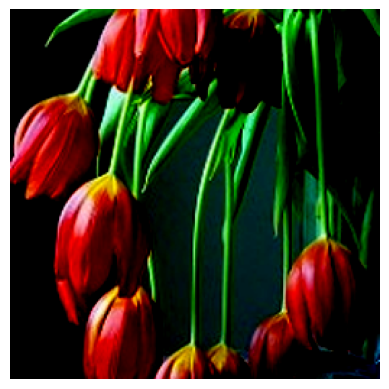

In [20]:
plt.imshow(next(iter(flowers_dataloader))[0][0][0:3, ...].permute(1, 2, 0))
plt.axis('off')
plt.show()

In [21]:
vae_history = []
discriminator_history = []

In [22]:
load_newest_models(decoder, encoder, discriminator, decoder_optimizer, encoder_optimizer, discriminator_optimizer)

Loaded models: decoder_2024-11-11_18-21-22.pt, encoder_2024-11-11_18-21-22.pt, discriminator_2024-11-11_18-21-22.pt


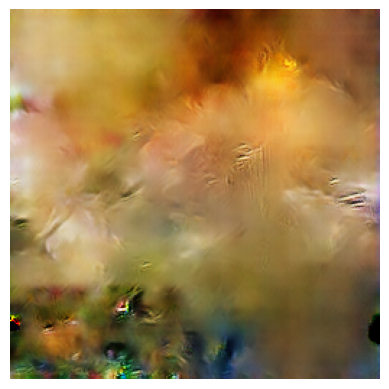

In [23]:
plot_random_image(decoder, latent_size)

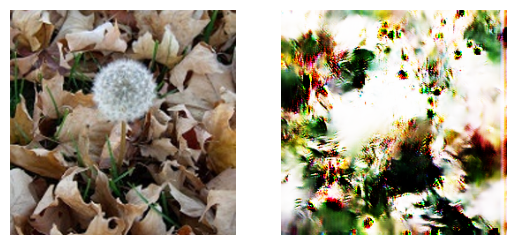

In [24]:
plot_images(decoder, encoder, next(iter(flowers_dataloader))[0][:1])

100%|██████████| 3/3 [00:00<00:00, 24.12it/s]


Explained variance: [0.00984194 0.00927888]


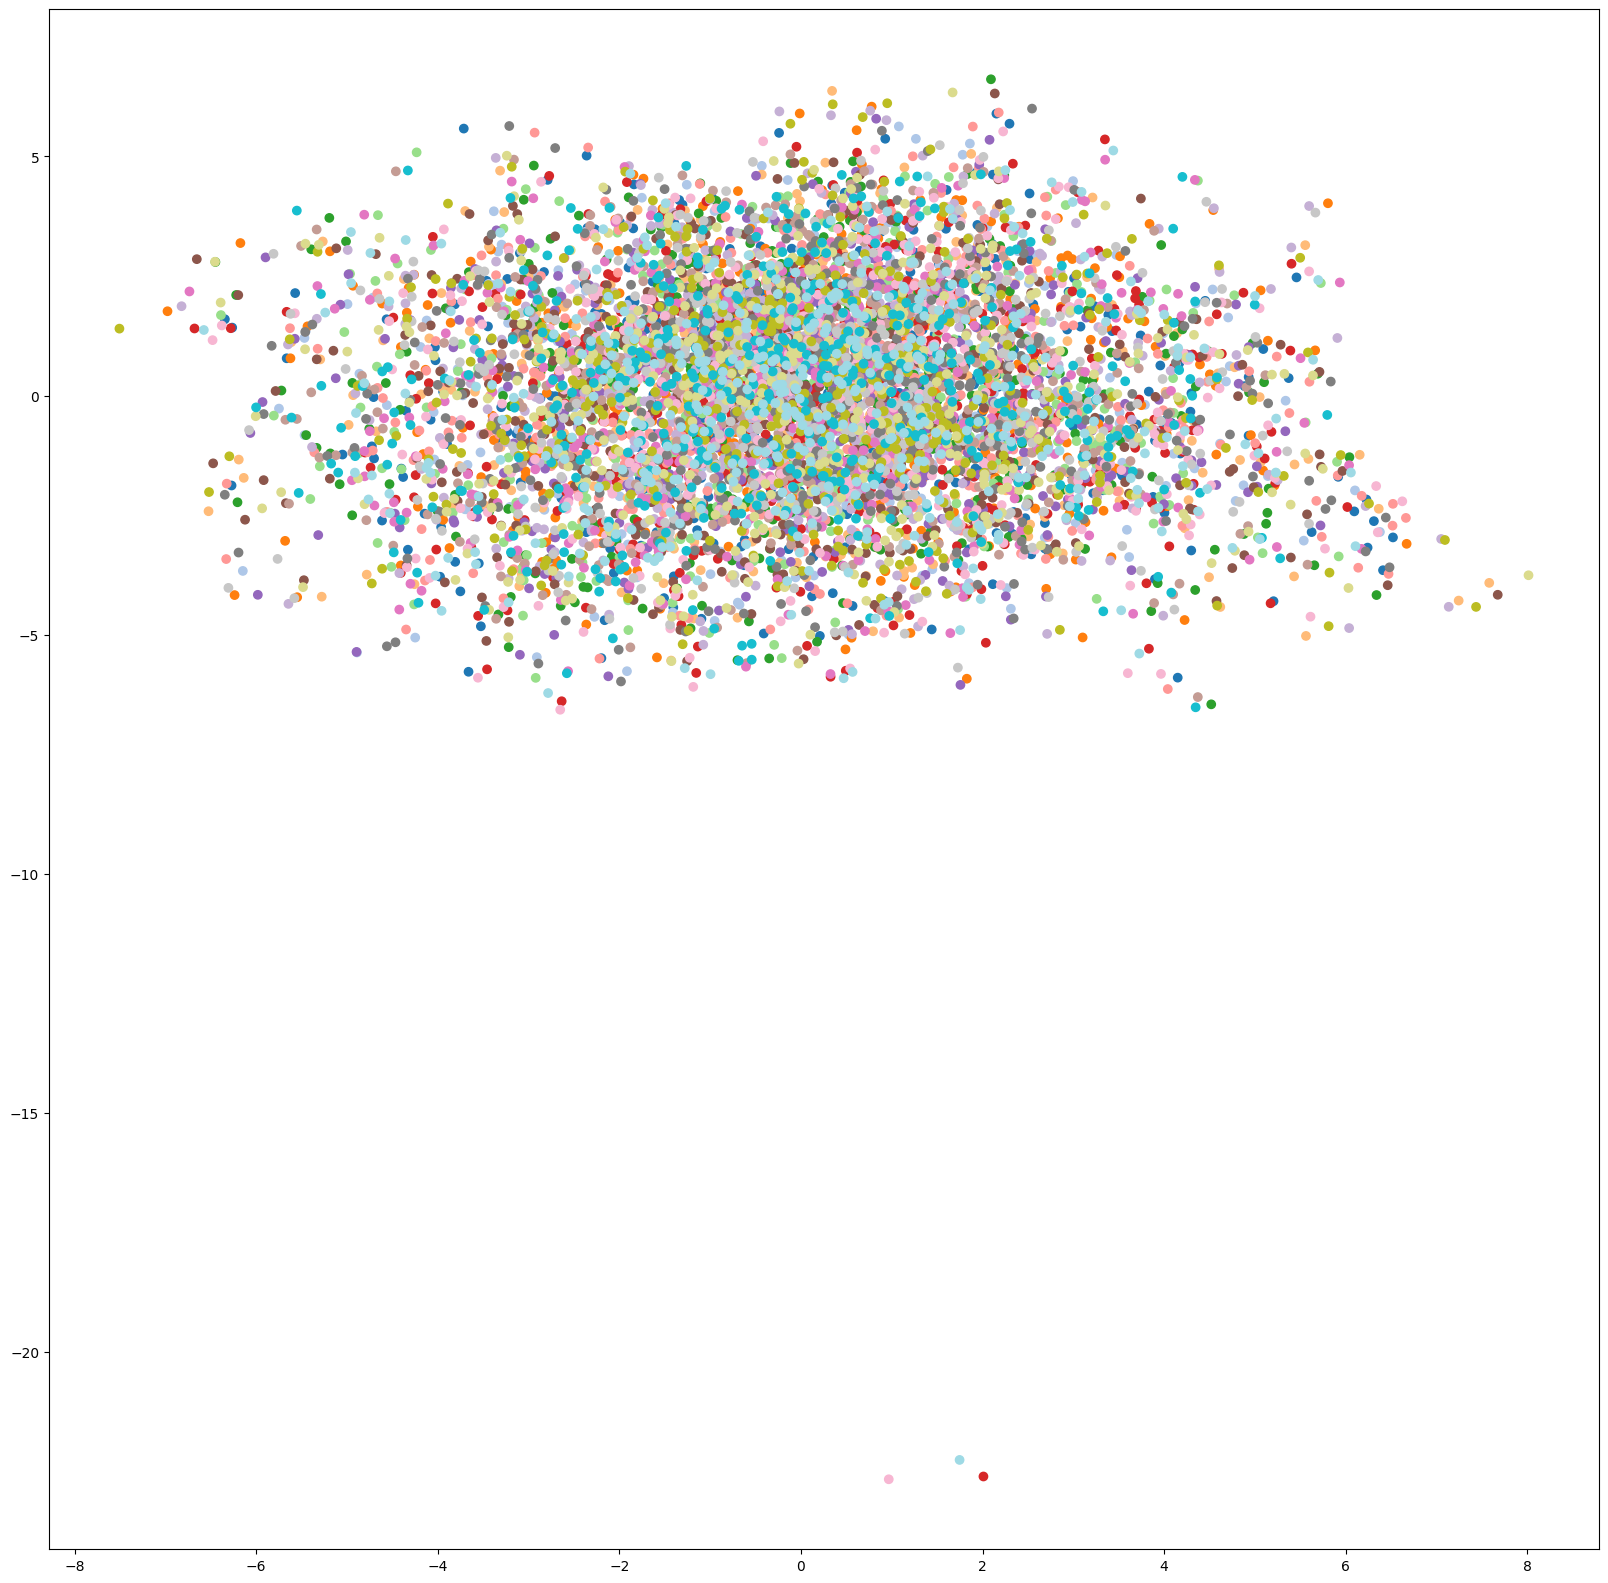

In [25]:
plot_hidden_distribution(encoder, flowers_dataloader, count_per_instance=3)

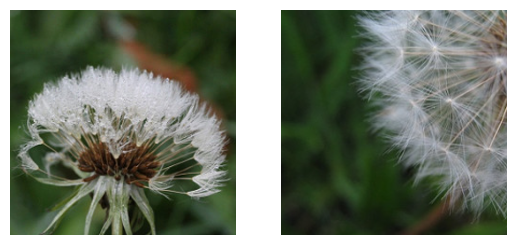

In [26]:
flowers_iter = iter(flowers_dataloader)

img1 = next(flowers_iter)[0][:1]
img2 = next(flowers_iter)[0][:1]

plot_interpolate(img1, img2, encoder, decoder, steps=30)

  0%|          | 0/374 [00:00<?, ?it/s]

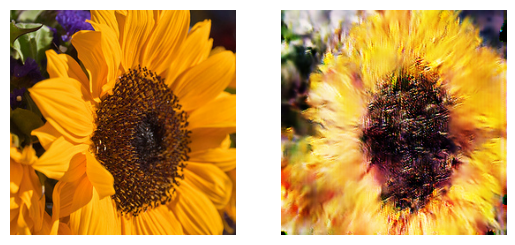

  6%|▌         | 21/374 [00:25<07:09,  1.22s/it]


KeyboardInterrupt: 

In [27]:
train(encoder, decoder, discriminator, flowers_dataloader, 100, encoder_optimizer, decoder_optimizer, discriminator_optimizer, img_width, vae_history, discriminator_history, initial_discriminator_part=8, gamma=0.04)

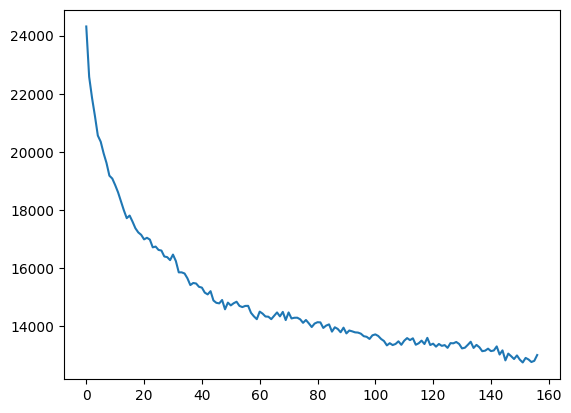

In [ ]:
plt.plot(vae_history)
# plt.plot(discriminator_history)
plt.title('Loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

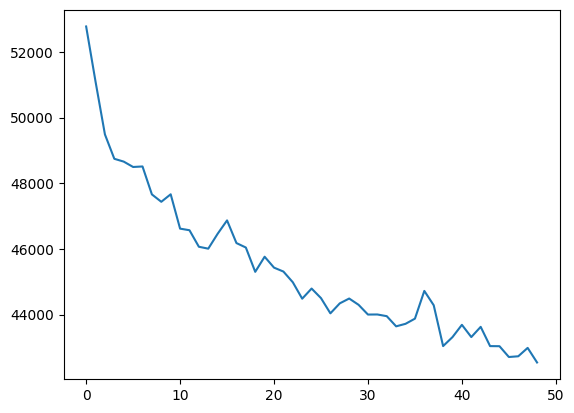

In [ ]:
# plt.plot(vae_history)
# # plt.plot(discriminator_history)
# plt.show()

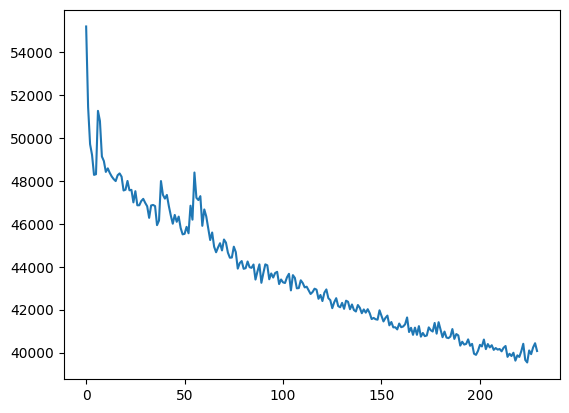

In [ ]:
# plt.plot(vae_history)
# plt.show()

In [ ]:
# plt.plot(vae_history)
# # plt.plot(discriminator_history)
# plt.show()

In [28]:
datetime_str = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

torch.save(decoder.state_dict(), f'models/decoder_{datetime_str}.pt')
torch.save(encoder.state_dict(), f'models/encoder_{datetime_str}.pt')
torch.save(discriminator.state_dict(), f'models/discriminator_{datetime_str}.pt')

torch.save(decoder_optimizer.state_dict(), f'models/decoder_optimizer_{datetime_str}.pt')
torch.save(encoder_optimizer.state_dict(), f'models/encoder_optimizer_{datetime_str}.pt')
torch.save(discriminator_optimizer.state_dict(), f'models/discriminator_optimizer_{datetime_str}.pt')